# Requirements

In [2]:
# import the necessary packages
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
import time

# Loading Model

In [3]:
PROTOTXT_ADDRESS = os.path.join("model", "MobileNet-SSD", "deploy.prototxt")
MODEL_ADDRESS = os.path.join("model", "MobileNet-SSD", "mobilenet_iter_73000.caffemodel")
CONFIDENCE = 0.2

# initialize the list of class labels MobileNet SSD was trained to
# detect, then generate a set of bounding box colors for each class
CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]

COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# load our serialized model from disk
net = cv2.dnn.readNetFromCaffe(PROTOTXT_ADDRESS, MODEL_ADDRESS)

# Object Detection Function

In [4]:
def detect_object(frame, network):
    # grab the frame dimensions and convert it to a blob
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 0.007843, (300, 300), 127.5)

    # pass the blob through the network and obtain the detections and predictions
    network.setInput(blob) 
    detections = network.forward()

    # loop over the detections
    for i in np.arange(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
		# the prediction
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the `confidence` is
		# greater than the minimum confidence
        if confidence > CONFIDENCE:
            # extract the index of the class label from the
			# `detections`, then compute the (x, y)-coordinates of
			# the bounding box for the object
            idx = int(detections[0, 0, i, 1])
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype('int')

            # draw the prediction on the frame
            label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
            cv2.rectangle(frame, (startX, startY), (endX, endY), COLORS[idx], 2)
            y = startY - 15 if startY - 15 > 15 else startY + 15
            cv2.putText(frame, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
    return frame

# Testing Object Detection Function

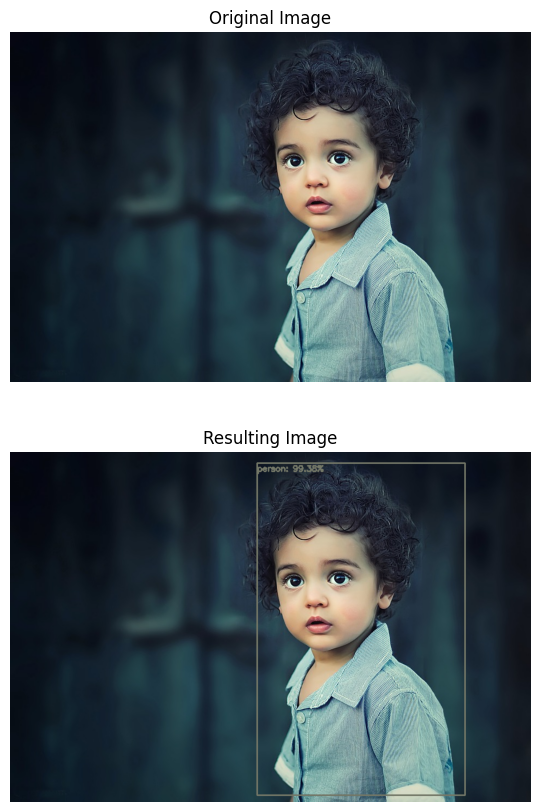

In [5]:
image = cv2.imread("images/kid1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")

image = detect_object(image, net)
plt.subplot(2, 1, 2)
plt.imshow(image)
plt.axis("off")
plt.title("Resulting Image")

plt.show()

# Real-time Object Detection Using WebCam

In [6]:
def visualize_fps(image, fps: int):
    # Check if the image is grayscale or colored.
    # If it's grayscale, set text color to white; if colored, set text color to green.
    if len(np.shape(image)) < 3:
        text_color = (255, 255, 255)  # White color for grayscale images.
    else:
        text_color = (0, 255, 0)  # Green color for colored images.

    # Define the row size for the text placement.
    row_size = 20 
    # Define the left margin for the text placement.
    left_margin = 24 

    # Set the font size and thickness for the text.
    font_size = 1
    font_thickness = 2

    # Format the FPS value into a string for displaying.
    fps_text = "FPS = {:.1f}".format(fps)
    # Set the text location on the image.
    text_location = (left_margin, row_size)
    
    # Place the FPS text on the image.
    cv2.putText(
        image,
        fps_text,
        text_location,
        cv2.FONT_HERSHEY_PLAIN,
        font_size,
        text_color,
        font_thickness,
    )

    # Return the modified image with the FPS text.
    return image

In [8]:
# Constants for camera settings
CAMERA_DEVICE_ID = 0  # ID for the camera device
IMAGE_WIDTH = 800  # Width of the captured image
IMAGE_HEIGHT = 600  # Height of the captured image
fps = 0  # Initial Frames Per Second (FPS) value

if __name__ == "__main__":  # Ensures that the code only runs when executed directly
    try:
        cap = cv2.VideoCapture(CAMERA_DEVICE_ID)  # Initialize video capture with the specified camera device ID

        while True:  # Infinite loop to continuously capture frames

            start_time = time.time()  # Record the start time to calculate FPS

            _, frame = cap.read()  # Capture a single frame from the camera

            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize the frame to the specified dimensions

            frame = detect_object(frame, net)

            # Display the frame with FPS overlay
            cv2.imshow("frame", visualize_fps(frame, fps)) 

            end_time = time.time()  # Record the end time to calculate FPS

            # Calculate the time taken to process the frame
            seconds = end_time - start_time 
            # Calculate FPS based on the time taken to process the frame
            fps = 1.0 / seconds

            # Break the loop if the 'Esc' key (ASCII 27) is pressed
            if cv2.waitKey(33) == 27:  
                break
    except Exception as e:  # Handle exceptions that may occur
        print(e)  # Print the exception message
    finally:
        cv2.destroyAllWindows()  # Close all OpenCV windows
        cap.release()  # Release the camera resource


# Real-time Object Detection Using Video Stream

In [7]:
# Constants for video settings
# Define the path to the video file using os.path.join
CAMERA_DEVICE_ID = os.path.join("videos", "Jobs_2.mp4")  # Path to the video file
IMAGE_WIDTH = 1000  # Width of the displayed image
IMAGE_HEIGHT = 600  # Height of the displayed image
fps = 0  # Initial Frames Per Second (FPS) value
FRAME_RATE = 30  # Desired frame rate
DURATION = 1 / FRAME_RATE  # Duration of each frame

if __name__ == "__main__":  # Ensures that the code only runs when executed directly
    try:
        cap = cv2.VideoCapture(CAMERA_DEVICE_ID)  # Initialize video capture with the specified video file path

        while True:  # Infinite loop to continuously capture frames
            start_time = time.time()  # Record the start time to calculate FPS

            _, frame = cap.read()  # Capture a single frame from the video
            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize the frame to the specified dimensions
            frame = detect_object(frame, net)
            end_time = time.time()  # Record the end time to calculate FPS

            # Calculate the time taken to process the frame
            seconds = end_time - start_time

            # If the processing time is less than the desired frame duration, wait for the remaining time
            if seconds < DURATION:
                time.sleep(DURATION - seconds)

            # Recalculate the time taken to process the frame including sleep time
            seconds = time.time() - start_time
            # Calculate FPS based on the time taken to process the frame
            fps = 1.0 / seconds

            # Display the frame with FPS overlay
            cv2.imshow("frame", visualize_fps(frame, fps))

            # Break the loop if the 'Esc' key (ASCII 27) is pressed
            if cv2.waitKey(33) == 27:  
                break
    except Exception as e:  # Handle exceptions that may occur
        print(e)  # Print the exception message
    finally:
        cv2.destroyAllWindows()  # Close all OpenCV windows
        cap.release()  # Release the video capture resource